In [1]:
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F

import logging

import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import DataParallel
from torch.nn import CrossEntropyLoss, MSELoss
import torch.optim as optim
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets.vision import VisionDataset
import torchvision.transforms.functional as F

import cv2 as cv
import numpy as np
import time
import os
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import random_split
from tqdm import tqdm
import pickle

import requests
import copy

from pathlib import Path
from PIL import Image
from imutils.paths import list_images, list_files
import os

import functions

In [2]:
cd /home/eccoope/pv-vision/

/home/eccoope/pv-vision


In [3]:
from pv_vision.nn import ModelHandler
from tutorials.unet_model import construct_unet

In [4]:
# class SolarDataset(VisionDataset):
#     """A dataset directly read images and masks from folder.    
#     """
#     def __init__(self, 
#                  root, 
#                  image_folder, 
#                  mask_folder,
#                  transforms,
#                  mode = "train",
#                  random_seed=42):
#         super().__init__(root, transforms)
        
#         self.image_path = Path(self.root) / image_folder
#         self.mask_path = Path(self.root) / mask_folder

#         if not os.path.exists(self.image_path):
#             raise OSError(f"{self.image_path} not found.")

#         if not os.path.exists(self.mask_path):
#             raise OSError(f"{self.mask_path} not found.")
            
            
#         self.image_list = sorted([c for c in list(list_files(self.image_path)) if '.ipynb_checkpoints' not in c])
#         self.mask_list = sorted([c for c in list(list_files(self.mask_path)) if '.ipynb_checkpoints' not in c])
#         self.image_list = np.array(self.image_list)
#         self.mask_list = np.array(self.mask_list)
        
#         np.random.seed(random_seed)
#         index = np.arange(len(self.image_list))
#         np.random.shuffle(index)
#         self.image_list = self.image_list[index]
#         self.mask_list = self.mask_list[index]
        
#     def __len__(self):
#         return len(self.image_list)

#     def __getname__(self, index):
#         image_name = os.path.splitext(os.path.split(self.image_list[index])[-1])[0]
#         mask_name = os.path.splitext(os.path.split(self.mask_list[index])[-1])[0]

#         if image_name == mask_name:
#             return image_name
#         else:
#             return False
    
#     def __getraw__(self, index):
#         if not self.__getname__(index):
#             raise ValueError("{}: Image doesn't match with mask".format(os.path.split(self.image_list[index])[-1]))
#         image = Image.open(self.image_list[index])
#         mask = Image.open(self.mask_list[index]).convert('L')
#         mask = np.array(mask)
#         mask = Image.fromarray(mask)

#         return image, mask

#     def __getitem__(self, index):
#         image, mask = self.__getraw__(index)
#         image, mask = self.transforms(image, mask)

#         return image, mask
    
# class Compose:
#     def __init__(self, transforms):
#         """
#         transforms: a list of transform
#         """
#         self.transforms = transforms
    
#     def __call__(self, image, target):
#         """
#         image: input image
#         target: input mask
#         """
#         for t in self.transforms:
#             image, target = t(image, target)
#         return image, target

# class FixResize:
#     # UNet requires input size to be multiple of 16
#     def __init__(self, size):
#         self.size = size

#     def __call__(self, image, target):
#         image = F.resize(image, (self.size, self.size), interpolation=transforms.InterpolationMode.BILINEAR)
#         target = F.resize(target, (self.size, self.size), interpolation=transforms.InterpolationMode.NEAREST)
#         return image, target

# class ToTensor:
#     """Transform the image to tensor. Scale the image to [0,1] float32.
#     Transform the mask to tensor.
#     """
#     def __call__(self, image, target):
#         image = transforms.ToTensor()(image)
#         target = torch.as_tensor(np.array(target), dtype=torch.int64)
#         return image, target

# class PILToTensor:
#     """Transform the image to tensor. Keep raw type."""
#     def __call__(self, image, target):
#         image = F.pil_to_tensor(image)
#         target = torch.as_tensor(np.array(target), dtype=torch.int64)
#         return image, target

# class Normalize:
#     def __init__(self, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
#         self.mean = mean
#         self.std = std
    
#     def __call__(self, image, target):
#         image = F.normalize(image, mean=self.mean, std=self.std)
#         return image, target

In [5]:
root = Path('/home/eccoope/pv-vision/examples/crack_segmentation/img_label_for_training')
transformers = Compose([FixResize(256), ToTensor(), Normalize()])

trainset = functions.SolarDataset(root, image_folder="train/img", 
        mask_folder="train/ann", transforms=transformers)

valset = functions.SolarDataset(root, image_folder="val/img", 
        mask_folder="val/ann", transforms=transformers)

testset = functions.SolarDataset(root, image_folder="testset/img", 
        mask_folder="testset/ann", transforms=transformers)

In [8]:
# Load pre-existing weights
unet = construct_unet(5)
unet = DataParallel(unet)
model = unet
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

weight_path = '/home/eccoope/el_img_cracks_ec/unet_oversample_low_final_model_for_paper/model.pt'
model.load_state_dict(torch.load(weight_path))

model.to(device);

In [9]:
model_output = 'out'
train_dataset=trainset
val_dataset=valset
test_dataset=testset

batch_size_val=10
test_loader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False)

In [10]:
batch_size_train=10
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)

In [11]:
# learning_rate=0.001
optimizer = Adam(model.parameters(), lr=0.01)
# optimizer = Adam(unet.parameters(), lr=0.01)
lr_scheduler = StepLR(optimizer, step_size=5, gamma=0.2)
num_epochs=1
criterion = MSELoss()
evaluate_metric=None
running_record = {'train': {'loss': []}, 'val': {'loss': []}}

save_dir='/home/eccoope/el_image_processing/example_checkpoints'
os.makedirs(save_dir, exist_ok=True)
save_name='model.pt'
log_interval = 10

cache_output = True

In [32]:
img, mask = train_loader.dataset.__getraw__(-2)

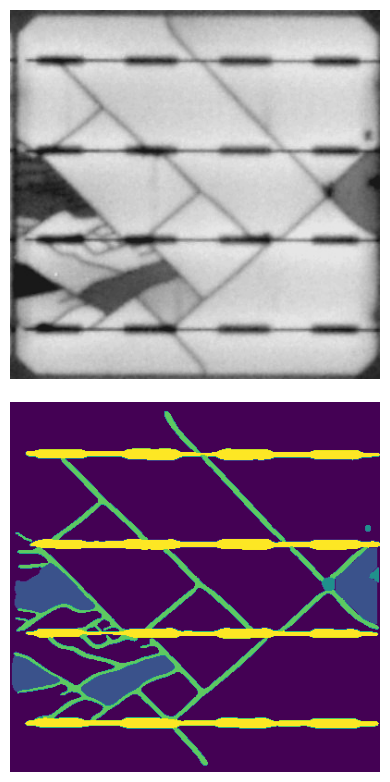

In [33]:
fig, ax = plt.subplots(nrows=2, figsize=(4,8))
ax[0].imshow(img)
ax[1].imshow(mask)
ax[0].axis('off')
ax[1].axis('off')
fig.tight_layout();

In [34]:
img, mask = train_loader.dataset. __getitem__(-2)

img.shape, mask.shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

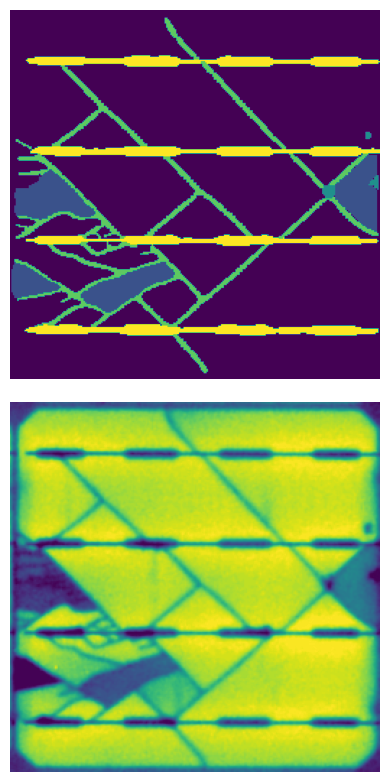

In [35]:
img2 = np.moveaxis(img.cpu().numpy()[0], 0, -1).T
fig, ax = plt.subplots(nrows=2, figsize=(4,8))
ax[0].imshow(mask)
ax[1].imshow(img2)
ax[0].axis('off')
ax[1].axis('off')
fig.tight_layout();

none = 0

dark = 1

cross = 2

crack = 3

busbar = 4

In [19]:
# for k, j in enumerate(train_loader):
#     print(type(k))

In [15]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# create a file handler
handler = logging.FileHandler(os.path.join(save_dir, 'modelhandler.log'))
handler.setLevel(logging.INFO)

# create a logging format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# add the handlers to the logger
logger.addHandler(handler)

# initial message
logger.info('ModelHandler initialized.')

cache = {}

In [16]:

# train_model()
for epoch in range(1, num_epochs + 1):
    print(f'Epoch {epoch} / {num_epochs}')
    print('-' * 10)
    
    # _train()
    # --------------------------------------------------------------
    model.train()
    loss_epoch = 0.0
    metric_epoch = None if evaluate_metric is None else 0.0
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
#         # if model_output:
#         #     output = output[model_output]
#         # check if criterion is cross entropy loss becasue the output shape is different
        if isinstance(criterion, nn.CrossEntropyLoss):
            loss = criterion(output, target.long())
        else:
            output_encoded = output.sum(axis = 1)
            loss = criterion(output_encoded, target.float())        # loss_epoch += loss.item() * data.size(0)
        loss.backward()
        optimizer.step()
        # if batch_idx % log_interval == 0:
        #     info1 = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item())
        #     info2 = ''
        #     logger.info(info1+info2)
        # if lr_scheduler is not None:
        #     lr_scheduler.step()
        # os.makedirs(os.path.join(save_dir, f'epoch_{epoch}'), exist_ok=True)
        # torch.save(model.state_dict(), os.path.join(save_dir, f'epoch_{epoch}', save_name))
        # logger.info(f'Saved model at epoch {epoch}')
        # loss_epoch /= len(train_loader.dataset)
        
#         loss_train, metric_train = loss_epoch, metric_epoch
#         # Evaluate
#         model.eval()
#         loss = 0.0
#         metric = None
#         if cache_output:
#             outall = []
#         with torch.no_grad():
#             for data, target in tqdm(val_loader):
#                 data, target = data.to(device), target.to(device)
#                 output = model(data)
#                 # if model_output:
#                 #     output = output[model_output]
#                 if cache_output:
#                     outall.append(output.cpu().numpy())
#                 # check if criterion is cross entropy loss becasue the output shape is different
#                 if isinstance(criterion, nn.CrossEntropyLoss):
#                     loss += criterion(output, target.long()).item() * data.size(0)
#                 else:
#                     loss += criterion(output, target.reshape(output.shape).float()).item() * data.size(0)
#                 if evaluate_metric is not None:
#                     metric += evaluate_metric(output, target.reshape(output.shape).float()).item()
#         loss /= len(val_loader.dataset)
#         if evaluate_metric is not None:
#             metric /= len(val_loader.dataset)
#         logger.info('Val epoch: {} \tAverage loss: {:.4f}'.format(epoch, loss))
#         if evaluate_metric is not None:
#             logger.info(f'{evaluate_metric.__name__}: {metric}')
#     loss_val, metric_val = loss, metric
#     print(f'Loss: {loss_train:.4f} (train) | {loss_val:.4f} (val)')
#     running_record['train']['loss'].append(loss_train)
#     running_record['val']['loss'].append(loss_val)
    
    
# with open(os.path.join(save_dir, 'running_record.pkl'), 'wb') as f:
#     pickle.dump(running_record, f)

Epoch 1 / 1
----------


100%|███████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.68it/s]


In [36]:
clases = output.argmax(axis = 1).detach().cpu().numpy()
clases.shape

(2, 256, 256)

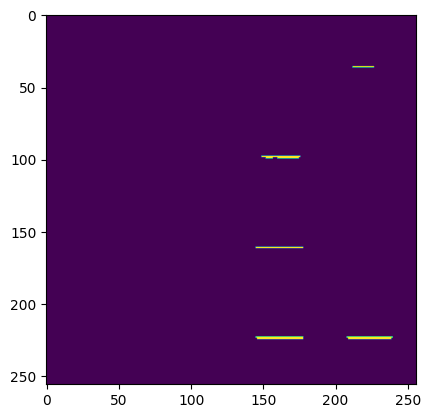

In [21]:
plt.imshow(clases[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


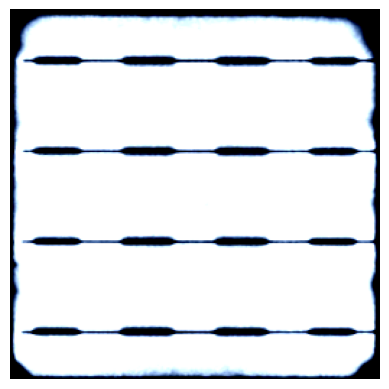

In [30]:
test = np.moveaxis(data.detach().cpu().numpy()[1], 0, -1)
plt.imshow(np.reshape(test, (256, 256, 3)))
plt.axis('off');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


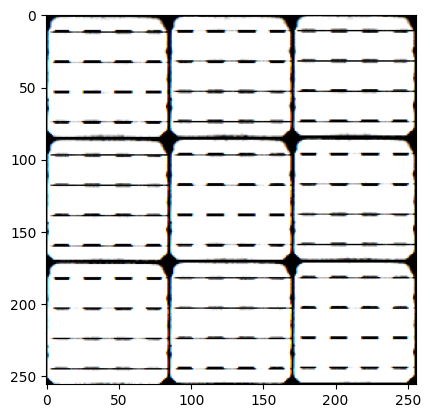

In [31]:
test = data.detach().cpu()[1]

plt.imshow(np.reshape(test, (256, 256, 3)))

In [15]:
output.shape

torch.Size([1, 5, 256, 256])

In [16]:
data.shape

torch.Size([1, 3, 256, 256])

In [17]:
target.shape

torch.Size([1, 256, 256])

In [22]:
torch.nn.functional.one_hot(target, num_classes=5).shape

torch.Size([1, 256, 256, 5])

In [41]:
inp = np.moveaxis(data.squeeze().cpu().numpy(), 0, -1)
o = output.squeeze().cpu().detach().numpy()

In [ ]:
torch.nn.functional.log_softmax(output)

In [45]:
o[0, :, :]

array([[2.355544 , 2.3661408, 2.3521807, ..., 2.285125 , 2.280646 ,
        2.2463336],
       [2.0388727, 2.072037 , 2.022228 , ..., 1.9478431, 1.9600416,
        1.908911 ],
       [1.8235718, 1.773192 , 1.5379966, ..., 1.4884822, 1.6730977,
        1.7020503],
       ...,
       [2.1666398, 2.2029598, 2.109092 , ..., 1.5544431, 1.74475  ,
        1.7580978],
       [2.2942193, 2.3457747, 2.2950802, ..., 1.8422351, 1.9598396,
        1.9397616],
       [2.2379212, 2.30651  , 2.2631986, ..., 2.039977 , 2.0849056,
        2.0631156]], dtype=float32)

In [46]:
o[1, :, :]

array([[-2.3471413 , -3.0147607 , -3.6637099 , ..., -3.3986123 ,
        -2.8348303 , -2.1642678 ],
       [-1.8556364 , -2.748943  , -3.3147647 , ..., -2.8556879 ,
        -2.3871408 , -1.558078  ],
       [-0.95728815, -1.2653148 , -1.4242887 , ..., -0.9116354 ,
        -0.84525466, -0.74012107],
       ...,
       [-1.5203435 , -1.4282036 , -1.4286063 , ..., -0.7526098 ,
        -0.73718137, -0.6782412 ],
       [-1.9053586 , -1.7604289 , -1.6072576 , ..., -1.1148937 ,
        -1.1186125 , -1.0500736 ],
       [-2.1898913 , -2.3312635 , -2.316063  , ..., -1.9290407 ,
        -1.9268904 , -1.7378783 ]], dtype=float32)

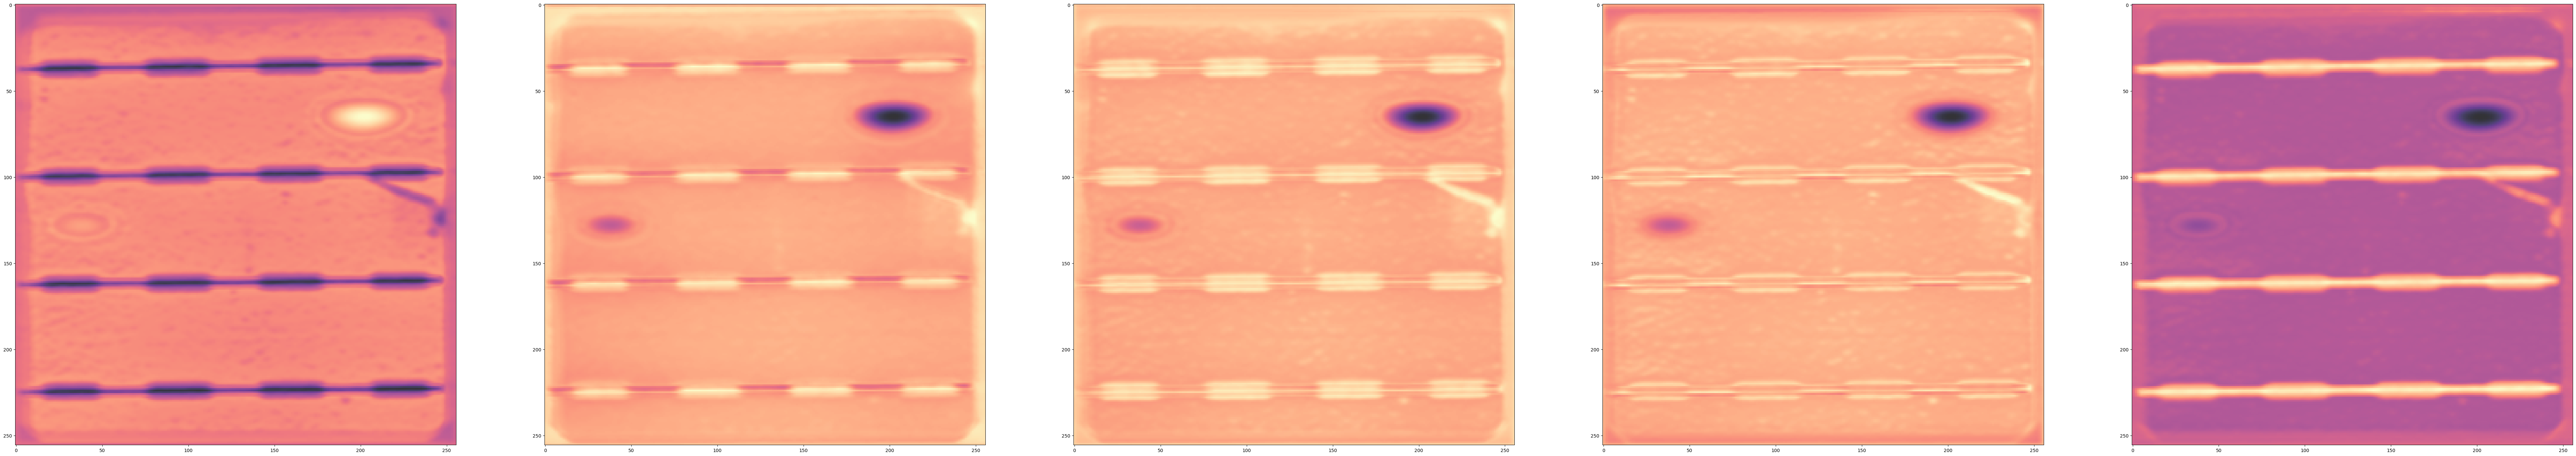

In [42]:
fig, axes = plt.subplots(1, 5, figsize=(100, 50))
for i, ax in enumerate(axes):
    # ax.imshow(inp, cmap='Greys_r')
    ax.imshow(o[i], cmap='magma', alpha=0.8)

In [96]:
resize = transforms.Compose([transforms.Resize((256, 256)), transforms.PILToTensor()])
color_map = {
    'dark': (68, 114, 148),
    'cross': (77, 137, 99),
    'crack': (165, 59, 63),
    'busbar': (222, 156, 83)
}

def get_masks(masks_raw):
    # masks_raw has the shape batch x n_masks x img_h x img_w, its elements are probability of prediction
    # masks_each has the shape batch x n_masks x img_h x img_w, its elements are boolen (whether belongs to this mask)
    masks_each = []
    # masks_all has the shape batch x img_h x img_w, its elements are labels of masks.
    masks_all = torch.nn.functional.softmax(torch.from_numpy(masks_raw), dim=1).argmax(dim=1)
    for masks in masks_all:
        busbar = masks==1
        crack = masks==2
        cross = masks==3
        dark = masks==4
        masks_each.append(torch.dstack([busbar, crack, cross, dark]).permute(2, 0, 1))
    return masks_each

def draw_mask(img, masks, colors=color_map, alpha=0.6):
    img = Image.fromarray(img)
    img = resize(img)

    combo = draw_segmentation_masks(img, masks, alpha=alpha, colors=[colors[key] for key in ['busbar', 'crack', 'cross', 'dark']])
    return F.to_pil_image(combo)

In [97]:
masks_each = get_masks(output.cpu().numpy().squeeze())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


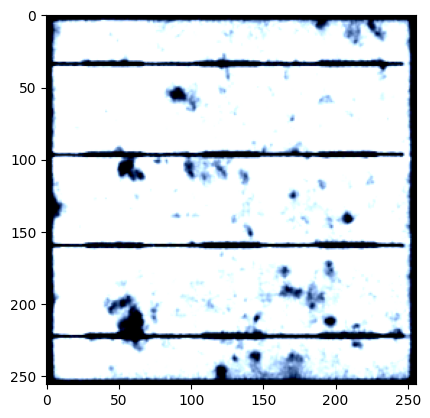

In [98]:
plt.imshow(np.moveaxis(data.cpu().numpy()[0], 0, -1))

In [99]:
temp = draw_segmentation_masks(data[0].cpu().type(torch.uint8), masks_each[0])

In [100]:
np.unique(temp)

array([  0,   1,   2,  51, 255], dtype=uint8)

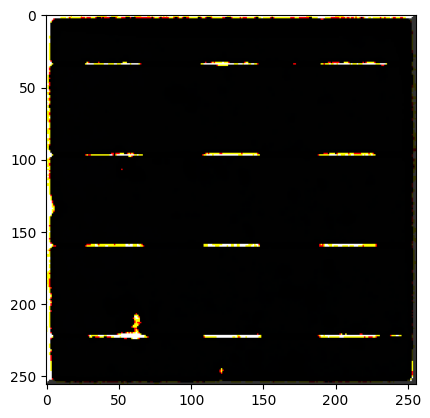

In [101]:
plt.imshow(np.moveaxis(temp.numpy(), 0, -1))

In [102]:
masks_each[0].shape

torch.Size([4, 256, 256])

In [103]:
temp = np.moveaxis(data.cpu().numpy()[0], 0, -1)

In [104]:
temp.shape

(256, 256, 3)

TypeError: Cannot handle this data type: (1, 1, 3), <f4

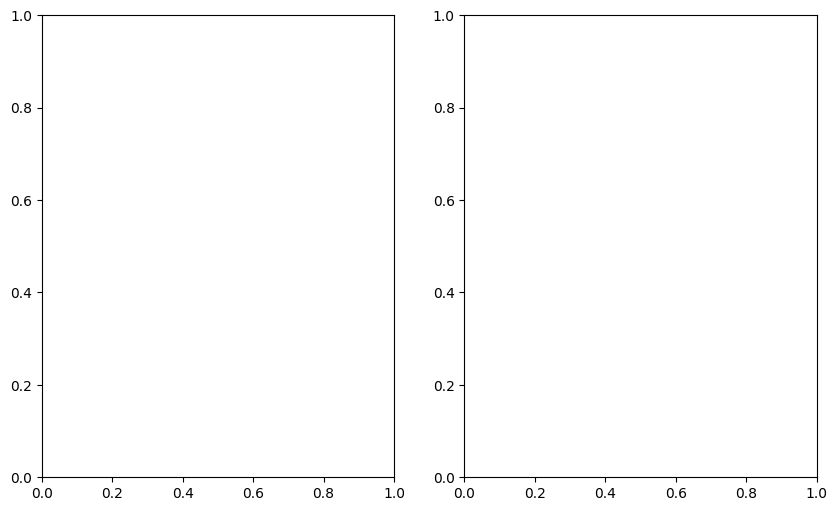

In [105]:
n = 0
fig, ax = plt.subplots(figsize=(10, 6), ncols = 2)
img = draw_mask(temp, masks_each[0])
ax[0].imshow(img)
ax[1].imshow(images[n])
ax[0].set_axis_off()
ax[1].set_axis_off()
fig.suptitle(name)
fig.tight_layout()

In [21]:
data.shape, target.shape

NameError: name 'data' is not defined

In [23]:
output.shape, target.long().shape

(torch.Size([10, 5, 256, 256]), torch.Size([10, 1, 256, 256]))